# Identification
Please indicate your name and parcours (e.g.: IMA, DIGIT, BIM, DAC, ..., Erasmus)

Student 1: Simon GROC

Student 2: Imane HIBAOUI

# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

def imshow_2(image1, image2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title(title1)
    axes[0].axis('off')
    
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title(title2)
    axes[1].axis('off')
    
    plt.show()


## Exercise 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [2]:
def SobelDetector(I, s):
    """ Array*double -> Array """
    Ix = convolve2d(I, np.array(([1, 0, -1], [2, 0, -2], [1, 0, -1])), mode='same')
    Iy = convolve2d(I, np.array(([1, 0, -1], [2, 0, -2], [1, 0, -1])).T, mode='same')
    norm = np.sqrt(Ix**2 + Iy**2)
    norm = norm > s
    return norm
    


2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [3]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    ILaplacian = convolve2d(I, np.array(([0, 1, 0], [1, -4, 1], [0, 1, 0])), mode='same')
    zeroCrossing = np.zeros_like(I)
    n, m = I.shape
    for i in range(1, n-1):
        for j in range(1,m-1):
            lMax = np.max(ILaplacian[i-1:i+2, j-1:j+2])
            lMin = np.min(ILaplacian[i-1:i+2, j-1:j+2])
            if lMax > 0 and lMin < 0 and lMax-lMin >s:
                zeroCrossing[i,j] = 1
    return zeroCrossing
    


3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

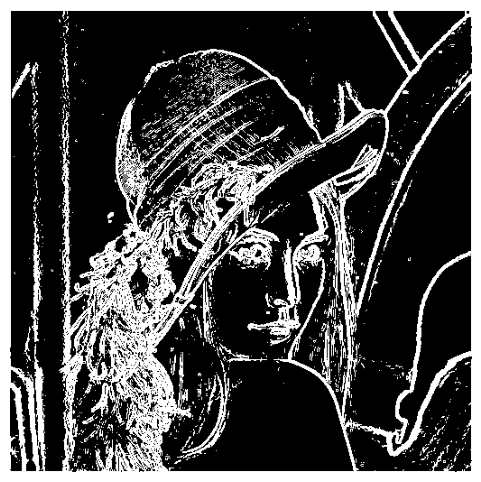

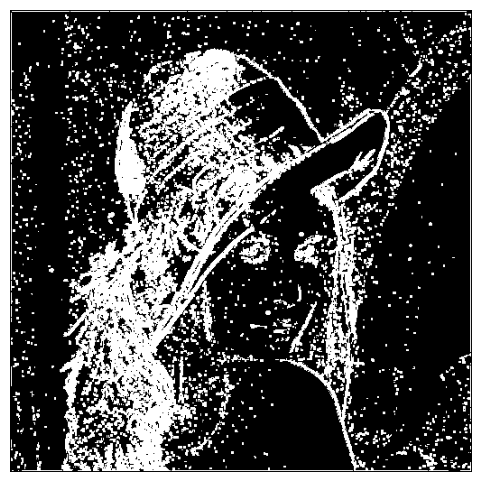

In [4]:
lena = np.array(Image.open("img\\lena.png"))
imshow(SobelDetector(lena, 70))
imshow(LaplacianDetector(lena, 70))


## Exercise 2: non maximum suppression

This exercise addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the notebook to see pixels value pointed by the mouse screen. **Warning**, this mode works only with jupyter notebook up to version 6).

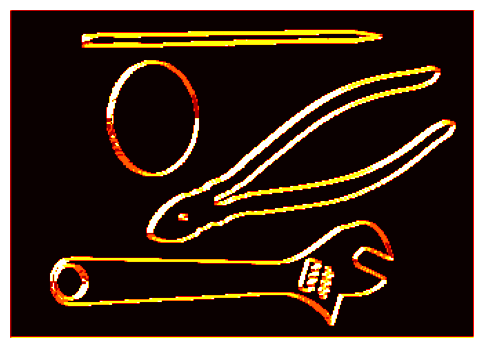

[0. 1. 2. 3. 4.]


In [5]:
sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

def gradient(image):
    Ix = convolve2d(image, sobel_x, mode='same')
    Iy = convolve2d(image, sobel_y, mode='same')
    Ig = np.sqrt(Ix**2 + Iy**2)  # Gradient magnitude
    Ior = orientation(Ix, Iy, Ig)  # Use the provided orientation() function
    return Ig, Ior
    
T = np.array(Image.open('img/tools.png'))
Ig, Ior = gradient(T)
imshow_hot(Ior)
print(np.unique(Ior))

Explain the different values given to a pixel by `orientation()`:

Your answer: Dans l'image générée par la fonction orientation(), les différentes valeurs attribuées aux pixels correspondent aux orientations des gradients dans l'image: 0 pour aucun gradient, 1 pour une orientation horizontale, 2 pour une orientation à 45°, 3 pour une orientation verticale, et 4 pour une orientation à diagonale.

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [6]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    n, m = Ig.shape
    res = np.zeros(Ig.shape)
    for i in range(1, n-1):
        for j in range(1, m-1):
            if Ior[i, j] == 1:  # Horizontal 
                if Ig[i, j] > Ig[i, j-1] and Ig[i, j] > Ig[i, j+1]:
                    res[i, j] = Ig[i, j]
            elif Ior[i, j] == 2:  # Diagonal 45°
                if Ig[i, j] > Ig[i-1, j+1] and Ig[i, j] > Ig[i+1, j-1]:
                    res[i, j] = Ig[i, j]
            elif Ior[i, j] == 3:  # Vertical
                if Ig[i, j] > Ig[i-1, j] and Ig[i, j] > Ig[i+1, j]:
                    res[i, j] = Ig[i, j]
            else:  # Diagonal 
                if Ig[i, j] > Ig[i-1, j-1] and Ig[i, j] > Ig[i+1, j+1]:
                    res[i, j] = Ig[i, j]
    return res

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


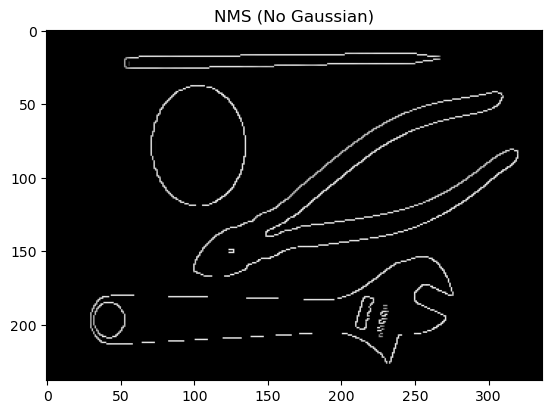

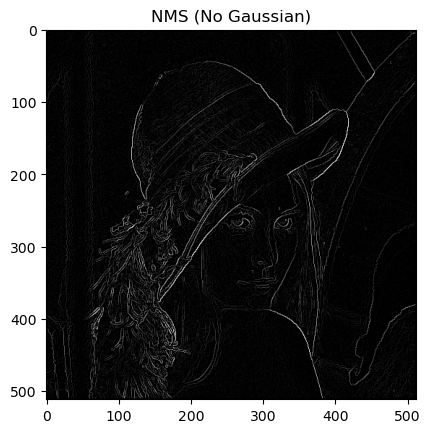

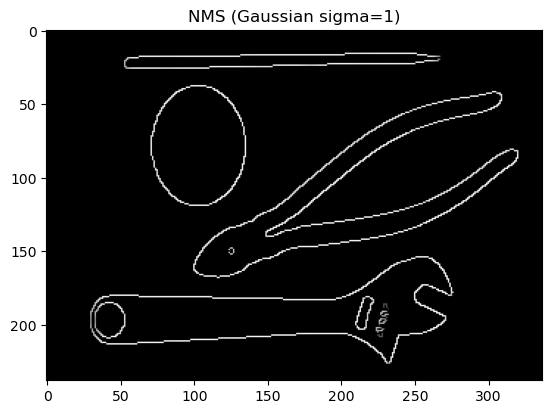

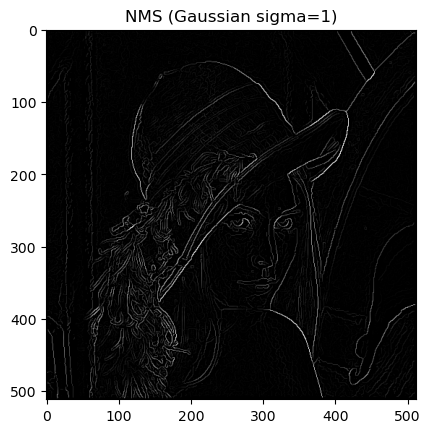

In [7]:
%matplotlib inline
def application(image, apply_gaussian=False, sigma=1):
    if apply_gaussian:
        h = gaussianKernel(sigma)
        image = convolve2d(image, h, mode='same') 
    Ig, Ior = gradient(image)
    G_nms = nms(Ig, Ior)
    
    title = f'NMS (Gaussian sigma={sigma})' if apply_gaussian else 'NMS (No Gaussian)'
    plt.imshow(G_nms, cmap='gray')
    plt.title(title)
    plt.show()

application(T, apply_gaussian=False)
application(lena, apply_gaussian=False)

application(T, apply_gaussian=True, sigma=1)
application(lena, apply_gaussian=True, sigma=1)


4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

In [8]:
# Le filtre gaussien (avec sigma=1) réduit le bruit de l'image, ce qui permet de détecter des bords continus. 
# Plus la valeur de sigma est élevée, plus le lissage est important, ce qui peut entraîner la perte de petits 
# détails tout en améliorant la netteté des bords principaux

## Exercise 3:  effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

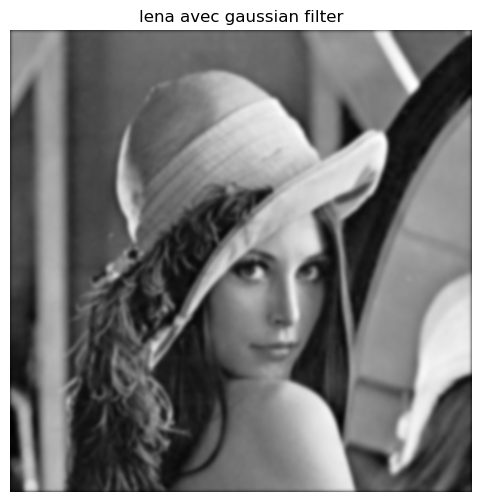

In [9]:
lena = np.array(Image.open("img\\lena.png"))
g = gaussianKernel(2)
L = convolve2d(lena, g, mode='same')
imshow(L, 'lena avec gaussian filter')


2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

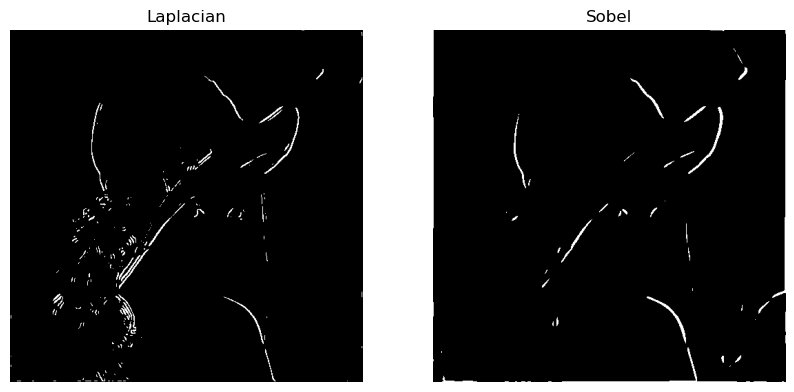

In [10]:
sob = SobelDetector(L, 180)
laplacian = LaplacianDetector(L,12)

imshow_2(laplacian, sob, 'Laplacian', 'Sobel')


3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

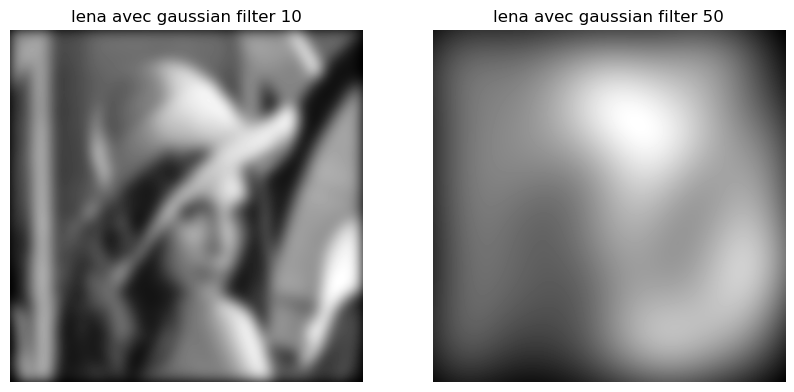

In [15]:
g10=gaussianKernel(10)
lena1 = convolve2d(L, g10, mode='same')
g50=gaussianKernel(50)
lena2 = convolve2d(L, g50, mode='same')
imshow_2(lena1, lena2, 'lena avec gaussian filter 10', 'lena avec gaussian filter 50')

In [ ]:
Le lissage réduit le bruit, mais un sigma élevé floute les contours et réduit leur précision.
Un sigma faible conserve mieux les contours tout en atténuant le bruit.

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.

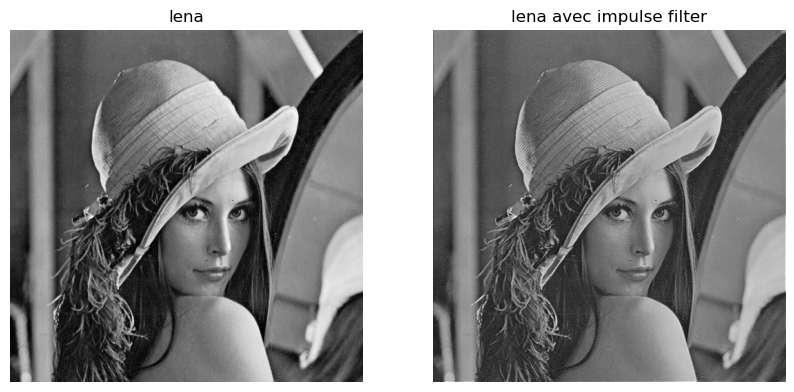

In [16]:
impulse_filter = np.array([[0, -1, 0], [-1, 5, 1], [0, -1, 0]])
lena_i= convolve2d(lena, impulse_filter, mode='same')
imshow_2(lena, lena_i, 'lena', 'lena avec impulse filter')

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

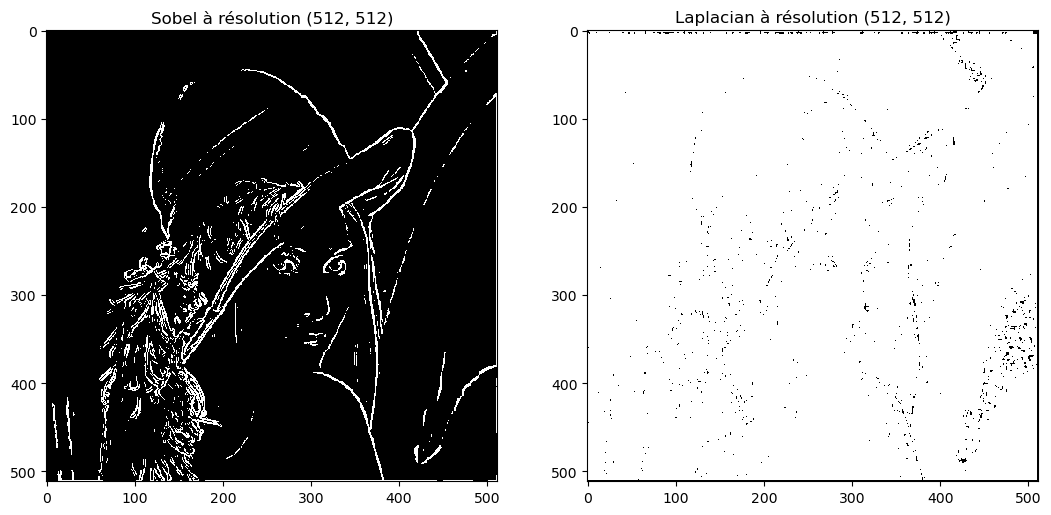

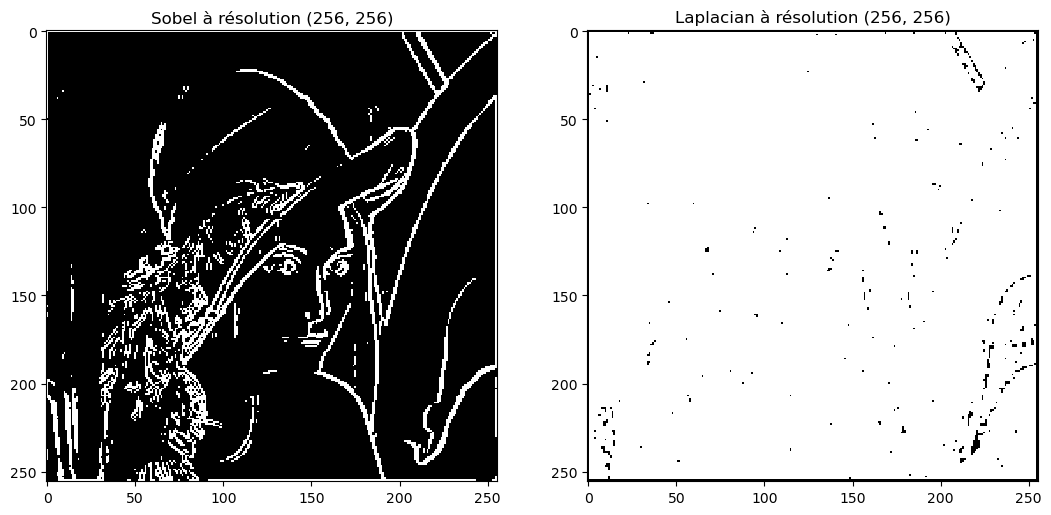

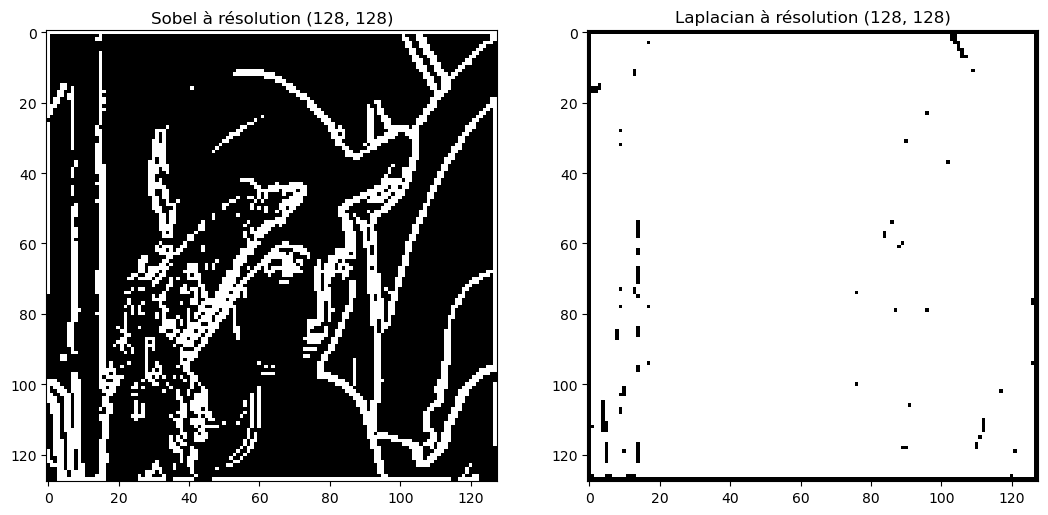

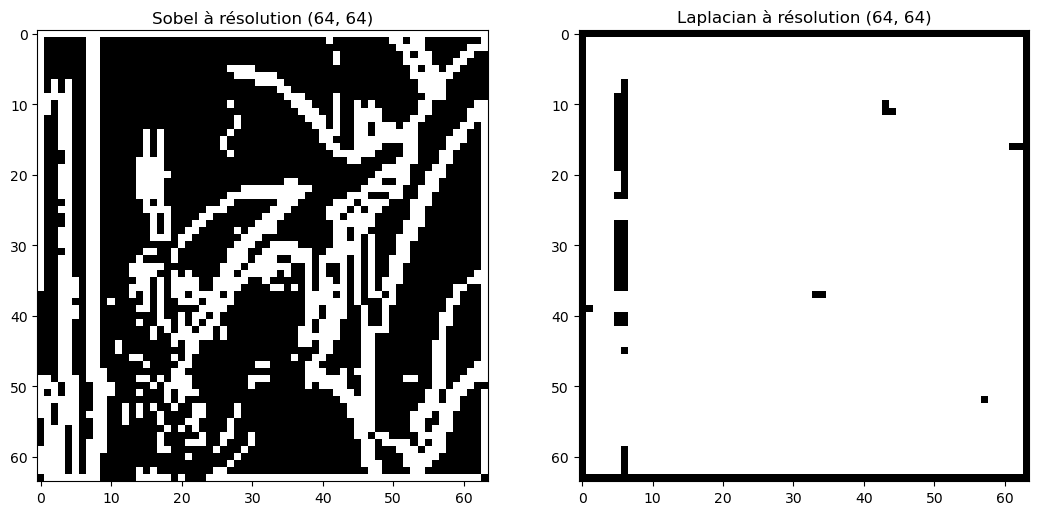

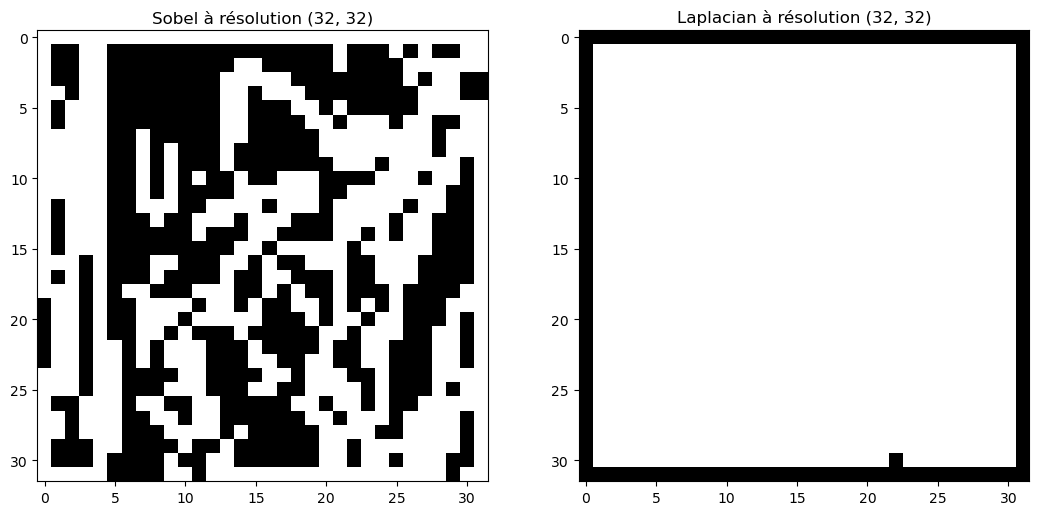

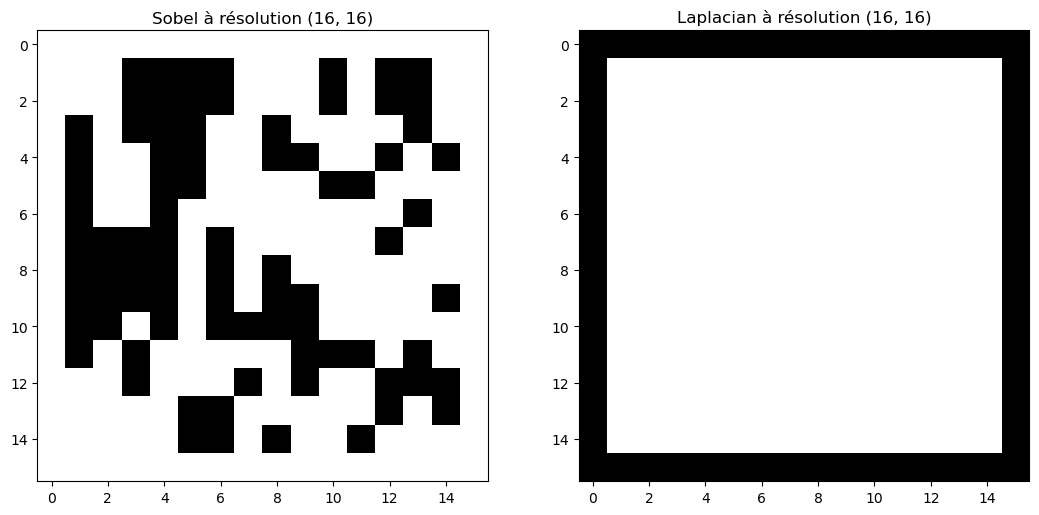

In [17]:
resolutions = []
current_image = lena

while current_image.shape[0] > 8 and current_image.shape[1] > 8:
    resolutions.append(current_image)
    current_image = current_image[::2, ::2]

sobel_results = [SobelDetector(img, 200) for img in resolutions]
laplacian_results = [LaplacianDetector(img, 10) for img in resolutions]

titres_sobel = [f'Sobel à résolution {img.shape}' for img in resolutions]
titres_laplacian = [f'Laplacian à résolution {img.shape}' for img in resolutions]

for sobel, laplacian, titre_sobel, titre_laplacian in zip(sobel_results, laplacian_results, titres_sobel, titres_laplacian):
    niceDisplay14([sobel, laplacian], [titre_sobel, titre_laplacian])


In [ ]:
À mesure que la résolution diminue, le détecteur Sobel conserve mieux les contours principaux, 
tandis que le détecteur Laplacien devient de plus en plus bruité et perd en précision, 
particulièrement aux basses résolutions.